<a href="https://colab.research.google.com/github/sarduous/CENG476_PROJECT/blob/main/Colab'e_ho%C5%9F_geldiniz_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CENG476_PROJECT

In [1]:
import os
import random
import zipfile
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==========================================
# 0. SETTINGS AND SEED FIXING
# ==========================================
# Ensuring reproducibility by fixing random seeds across all libraries
print("0. Fixing Random Seeds for Reproducibility...")
SEED = 31
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Random Seed set to: {SEED}")

# ==========================================
# 1. KAGGLE CONFIGURATION AND DATA DOWNLOAD
# ==========================================
print("\n1. Configuring Kaggle API...")

kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Check if kaggle.json is already present
if not os.path.exists(kaggle_json_path):
    print("kaggle.json not found. Please upload your 'kaggle.json' file now.")
    print("If you are on Google Colab, a file upload button will appear.")

    try:
        from google.colab import files
        uploaded = files.upload()

        # Move the uploaded file to the .kaggle directory
        for filename in uploaded.keys():
            if filename == 'kaggle.json':
                os.rename(filename, kaggle_json_path)
                print("kaggle.json uploaded and moved successfully.")
    except ImportError:
        print("Google Colab environment not detected. Please manually place 'kaggle.json' in ~/.kaggle/")
else:
    print("kaggle.json found. Proceeding...")

# Set permissions
if os.path.exists(kaggle_json_path):
    os.chmod(kaggle_json_path, 0o600)

    # Download and extract the dataset
    print("Downloading Dataset...")
    os.system('kaggle datasets download -d mohamedhanyyy/chest-ctscan-images --force')

    with zipfile.ZipFile("chest-ctscan-images.zip", 'r') as zip_ref:
        zip_ref.extractall("./data")
        print("Dataset extracted successfully.")
else:
    print("ERROR: Kaggle API credentials not found. Cannot download dataset.")
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
with open(kaggle_json_path, 'w') as f:
    json.dump({"username": kaggle_username, "key": kaggle_api_token}, f)
os.chmod(kaggle_json_path, 0o600)

# Download and extract the dataset
os.system('kaggle datasets download -d mohamedhanyyy/chest-ctscan-images --force')
with zipfile.ZipFile("chest-ctscan-images.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

# ==========================================
# 2. DATA PREPARATION & PREPROCESSING
# ==========================================
print("\n2. Initializing Data Generators...")
train_dir = './data/Data/train'
test_dir = './data/Data/test'
BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

# Data Augmentation (Applied only to Training Data)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling only for Validation/Test Data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical'
)

# --- CREATIVE STRATEGY 1: CLASS WEIGHTS (Handling Imbalance) ---
# Item 6: Special data strategy to address class imbalance
print("\n[Creative Strategy] Computing Class Weights to handle data imbalance...")
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights_dict}")

# ==========================================
# 3. MODEL ARCHITECTURE DESIGN
# ==========================================
print("\n3. Constructing the VGG16-Based Model...")
# Transfer Learning Base (VGG16 pre-trained on ImageNet)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing the base model for the first stage of training

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Flatten()(x)

# Batch Normalization & Dropout for Regularization
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# ==========================================
# 4. STAGE 1: FEATURE EXTRACTION TRAINING
# ==========================================
print("\n--- STAGE 1: Transfer Learning (Training Classifier Head Only) ---")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('stage1_model.keras', save_best_only=True)
]

history_stage1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# ==========================================
# 5. STAGE 2: FINE-TUNING
# ==========================================
print("\n--- STAGE 2: Fine-Tuning (Unfreezing & Refining Representations) ---")

# Unfreeze the last convolutional block of VGG16 (Block 5)
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Re-compile the model with a very low learning rate to prevent catastrophic forgetting
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), # Ultra-low LR
              loss='categorical_crossentropy', metrics=['accuracy'])

# Update Callbacks
callbacks_fine = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_finetuned_model.keras', save_best_only=True)
]

# Continue training from the last epoch of Stage 1
total_epochs = 35 # 20 + 15 additional epochs
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_stage1.epoch[-1], # Resume training
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks_fine
)

# ==========================================
# 6. RESULTS AND REPORTING
# ==========================================
print("\n--- Generating Performance Plots and Reports ---")

# Combine history from both stages
acc = history_stage1.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_stage1.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_stage1.history['loss'] + history_fine.history['loss']
val_loss = history_stage1.history['val_loss'] + history_fine.history['val_loss']

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.plot([len(history_stage1.history['accuracy'])-1, len(history_stage1.history['accuracy'])-1],
         plt.ylim(), label='Fine Tuning Start', linestyle='--')
plt.legend()
plt.title('Accuracy Improvement with Fine-Tuning')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.plot([len(history_stage1.history['loss'])-1, len(history_stage1.history['loss'])-1],
         plt.ylim(), label='Fine Tuning Start', linestyle='--')
plt.legend()
plt.title('Loss Reduction')
plt.show()

# Evaluation
print("\nEvaluating on Test Set (Shuffle=False)...")
eval_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
Y_pred = model.predict(eval_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = eval_generator.classes
class_names = list(eval_generator.class_indices.keys())
short_names = [n.split('_')[0] for n in class_names]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=short_names, yticklabels=short_names)
plt.title(f'Confusion Matrix (Final Acc: {val_acc[-1]:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- DETAILED PERFORMANCE REPORT ---")
print(classification_report(y_true, y_pred, target_names=short_names))

print("Code execution completed successfully. Ready for submission.")

0. Fixing Random Seeds for Reproducibility...
Random Seed set to: 31

1. Configuring Kaggle API...
kaggle.json not found. Please upload your 'kaggle.json' file now.
If you are on Google Colab, a file upload button will appear.


ERROR: Kaggle API credentials not found. Cannot download dataset.


NameError: name 'kaggle_username' is not defined

Found 315 images belonging to 4 classes.


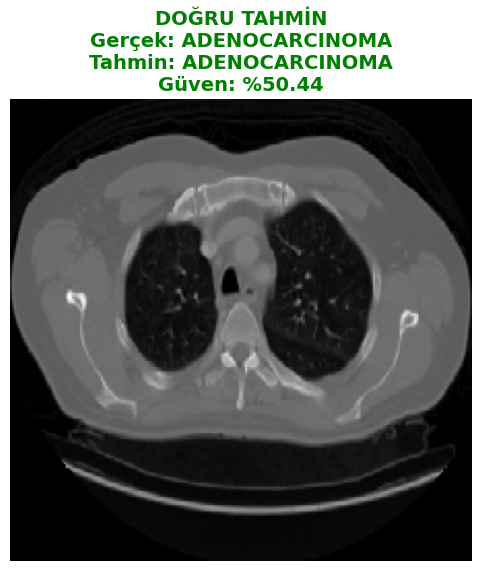

In [4]:
# TEST
import numpy as np
import matplotlib.pyplot as plt

def predict_random_image():
    demo_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=True
    )

    img, label = next(demo_gen)

    prediction = model.predict(img, verbose=0)
    pred_class_index = np.argmax(prediction)
    true_class_index = np.argmax(label)
    confidence = np.max(prediction) * 100

    class_indices = train_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}

    pred_name = idx_to_class[pred_class_index].split('_')[0].upper()
    true_name = idx_to_class[true_class_index].split('_')[0].upper()

    plt.figure(figsize=(6, 6))
    plt.imshow(img[0])
    plt.axis('off')

    status_color = 'green' if pred_class_index == true_class_index else 'red'
    result_text = "DOĞRU TAHMİN" if pred_class_index == true_class_index else "YANLIŞ TAHMİN"

    plt.title(f"{result_text}\nGerçek: {true_name}\nTahmin: {pred_name}\nGüven: %{confidence:.2f}",
              color=status_color, fontsize=14, fontweight='bold')

    plt.show()

predict_random_image()